# Flood Risk
## Dike Ring 14

````{note}
This page is generated from an `*.ipynb` file which requires several auxiliary files, all of which can be downloaded using the link below.
```{eval-rst}
:download:`Download zip file for this exercise.<exercise_flood_risk.zip>`
```
````

The overall objective of this assignment is to make a step from the simple FN/FD curves we have in the book to work on something 'real' and to make 'real' engineering decisions about how to modify a dike ring to meet safety standards. This exercise is based on a risk assessment of the Netherlands from around 10 years ago called VNK (veiligheid Nederland in kaart, or mapping Dutch (flood) safety. It was done in the runup to changing the safety standards in 2017. You can find more about the project [here](https://www.helpdeskwater.nl/onderwerpen/waterveiligheid/programma-projecten/veiligheid-nederland/publicaties/), and a report specifically about the case [here](https://www.helpdeskwater.nl/onderwerpen/waterveiligheid/programma-projecten/veiligheid-nederland/publicaties/dijkringrapporten/dijkringrapporten/fase-1a/14-zuid-holland/). The first website has some English reports, but unfortunately the Dike Ring 14 report is only in Dutch.

*First the case is introduced, then some examples using the pre-prepared code are given to show you how to use it. Then you are asked to use the code to decide which repairs to specific dike segments should be done to see if you can meet the safety criteria!*

*Our apologies in advance that the code does not meet the Golden Rules. Although it might not look pretty, we trust that it is clear enough to be able to learn about risk!*

## Overview of the case study

The entire dike ring that protects South Holland is divided into 13 segments, which have been chosen such that the flooding that occurs after a breach is not dependent on the location of the breach itself. This results in significantly fewer flooding analyses that must be carried out. In addition, all possible breach locations within a single segment do not have to be considered. For South Holland, 7 segments are defined along the Nieuwe Waterweg (i.e., the river, behind the Maeslant Barrier) and 6 segments are defined along the coast.

```{figure} ./figures/map-dike-segments.PNG
---
width: 500px
name: map_segments
---
```
All segments along the river are dikes and segments along the sea are dunes, with the following exceptions:
- Segment 3: Park Sluices in Rotterdam
- Segment 10: Scheveningen outlet sluice
- Segment 11: Scheveningen Bouldevard
    
### How does a flood risk analysis work?
    
We are essentially creating a probability mass function, where the random variable is fatalities or economic damage. Since we can't wait a few million years watch the dike ring fail to get a good estimate of the actual distribution, we try to simulate all possible combinations of floods. However, the actual flooding process is complicated: due to the river or sea conditions a dike or dune is broken (this is called a breach), water rushes into the protected area, depending on the flooding depth people may die and infrastructure is damaged. Sometimes we are able to warn and evacuate people, but there is a chance these systems do not work. Reality is extremely complex, so we simplify the process in our flood modeling studies, using the following steps:
a. assume a levee or dune is breached
b. estimate the resulting flood depth in the (formerly) protected area
c. calculated economic damage and fatalities as a function of water depth
d. modify the above value depending on the status of warning and evacuation systems
e. repeat this for many breach locations
    
As such, each scenario returns a finite number of fatalities or damage, which is why the distribution is discrete. Of course, we need to also quantify the probability of each scenario. Although it sounds complex, it is actually simple to represent using conditional probability if we can assume:
$$\textrm{P}(x_i)=\textrm{P}(x_i|D,W,E)\cdot\textrm{P}(D)\cdot\textrm{P}(W)\cdot\textrm{P}(E)$$

where $x_i$ is our risk metric of choice (i.e., economic damage or fatalities) and $D$, $W$ and $E$ represnt water depth, warning and evacuation status, respectively. Given the scenario-based approach where a fixed value is determined for $x_i$, it is clear that this type of analysis creates a descrete random variable. Furthermore, the equation above indicates that single values of $D$, $W$ and $E$ are used, but in theory one could integrate over each of these variables.
    
An example of the flood depth analysis is shown below for a breach in segment 12:
```{figure} ./figures/flood-depth-12.PNG
---
width: 500px
name: flood_depth_12
---
```

## Exercise Instructions

An Excel file has been prepared that includes the results from the risk analysis. Each row is a scenario, with a `Scenario_ID` and associated probability of occurrence (`scenario_probability`). The column `failed_segments` lists which dike segments are assumed to have failed in the particular scenario. Consequences are specifies in the last 8 columns (described below).

Your task is to determine which **dike segments** you should repair to improve the safety of Dike Ring 14. Unfortunately due to the available budget, **you can only afford to repair 3 segments.** Thus, your task is to identify 3 segments to repair and justify your decision for doing so (there are some cells below where you can type your answer). You are free to consider both life loss and economic damage in your evaluation.

The next set of cells will get you started with the helper functions, then you are free to use them to work on the assignment. First, start by importing the required packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Import special functions created to help with this assignment:

In [2]:
from functions import find_scenarios_with_segment_i
from functions import assemble_analysis_cases
from functions import exceedance_prob
from functions import plot_curves
from functions import sensitivity_analysis
from functions import compute_benefit
from functions import set_TUDstyle

Load data and take a look at it:

In [3]:
df = pd.read_excel(r'Prob_Cons.xlsx')
df.head()

,Scenario_ID,scenario_probability,failed_segments,case_1_d,case_1_n,case_2_d,case_2_n,case_3_d,case_3_n,case_4_d,case_4_n
0,1,0.000021,12,5700,600,5700,460,5700,420,5700,300
1,2,0.000016,2,1400,200,1400,150,1400,140,1400,99
2,3,0.000005,"2,7",1800,210,1800,160,1800,150,1800,110
3,4,0.000004,5,1600,3700,1600,2800,1600,2600,1600,1800
4,5,0.000004,6,720,40,720,30,720,30,710,20


### Evacuations (labeled Case 1-4)

*As you can see above, the dataframe has 8 columns labeled `case_*_*`. The last character denotes either fatalities or damage with `n` or `d`, respectively.*

The consequences in each scenario are dependent on whether or not there is a flood warning and time for an ordered evacuation or not. To account for this, 4 sub-scenarios are considered, and the probability of each is weighted equally in the total FN curve (cases are combined in `exceedance_prob`). For the response to a dike breach there are 4 conditions considered (in order of table on Page 139, Bijlage I):
- flood unexpected and no evacuation
- flood unexpected with an unorganized evacuation
- flood expected with an unorganized evacuation
- flood expected with an organized evacuation

It is interesting to know how this is incorporated in the analysis, but you can ignore this when going through the exercise, since it becomes unecessarily complicated.

In [4]:
df.describe()

,Scenario_ID,scenario_probability,case_1_d,case_1_n,case_2_d,case_2_n,case_3_d,case_3_n,case_4_d,case_4_n
count,50.00000,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000
mean,25.50000,1.290931e-06,12549.780000,8603.360000,12493.000000,6631.500000,12491.000000,5988.66000,12471.100000,4269.280000
std,14.57738,3.822669e-06,8887.756677,8037.445146,8839.023921,6213.314184,8839.795512,5578.15815,8835.288088,3965.545056
min,1.00000,8.830000e-09,230.000000,8.000000,230.000000,6.000000,230.000000,6.00000,230.000000,4.000000
25%,13.25000,4.402500e-08,5475.000000,2225.000000,5475.000000,1700.000000,5475.000000,1600.00000,5475.000000,1100.000000
50%,25.50000,1.125000e-07,11000.000000,3800.000000,11000.000000,2950.000000,11000.000000,2700.00000,11000.000000,1900.000000
75%,37.75000,4.797500e-07,17000.000000,15750.000000,17000.000000,11750.000000,17000.000000,10750.00000,17000.000000,7775.000000
max,50.00000,2.140000e-05,33000.000000,29000.000000,33000.000000,22000.000000,33000.000000,20000.00000,33000.000000,14000.000000


The function `find_scenarios_with_segment_i` will ask for the dike segment(s) of interest (as a list) and return all of the scenarios where a breach in this segment is considered.

In [5]:
print(find_scenarios_with_segment_i.__doc__)
find_scenarios_with_segment_i([12], df)

Given a list of segments, return set of dependent scenarios.


,Scenario_ID,scenario_probability,failed_segments,case_1_d,case_1_n,case_2_d,case_2_n,case_3_d,case_3_n,case_4_d,case_4_n
0,1,2.140000e-05,12,5700,600,5700,460,5700,420,5700,300
8,9,9.480000e-07,"12,13",11000,2000,11000,1600,11000,1400,11000,1000
49,50,2.450000e-08,"8,12,13",19000,2700,19000,2100,19000,1900,19000,1400


## Compute exceedance probabilities

Now that we have explored the database of scenarios, let's move towards evaluating risk. Before assembling the risk curves, we will extract the probability associated with each scenario, and use a prepared function (`assemble_analysis_cases`) to make the process easier.

In [6]:
scenario_prob = df.iloc[:,1]
damage_and_fatality_cases = assemble_analysis_cases(df)

choose_damage_or_fatality = 'fatality'
case = damage_and_fatality_cases[choose_damage_or_fatality]

The function `exceedance_prob` computes the FN or FD curve depending on the case that is provided. And the function `plot_curves` will plot them with the limit line.

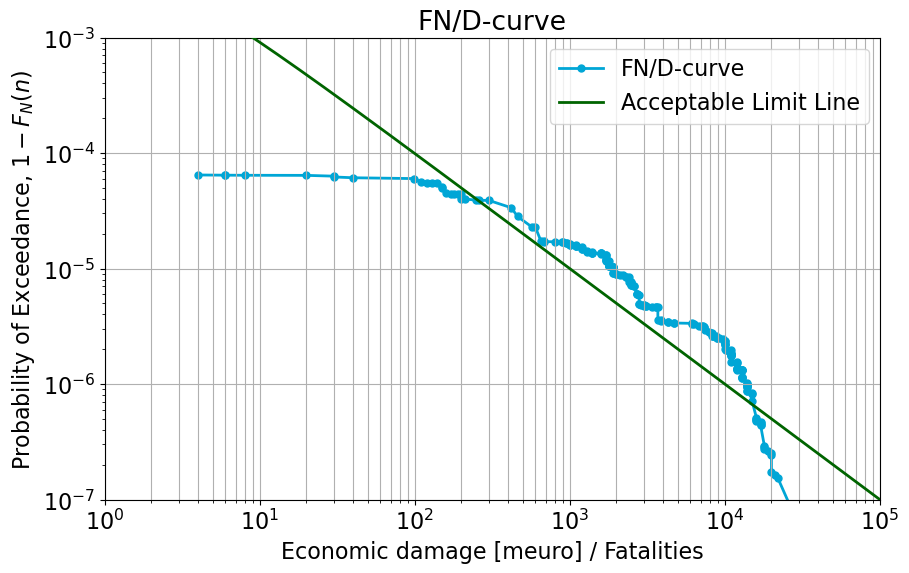

In [7]:
N_D_ordered_test, exceed_prob_test, complete_table = exceedance_prob(case, scenario_prob)
plot_curves(N_D_ordered_test, exceed_prob_test)

## Modify the system and see how the FN (or FD) curve changes

The function above allows the user to choose which dike segments to repair, then the relevant scenarios are removed from consideration. Play with the segments and see what the most important repairs should be to improve the system risk.

Segment [12, 13] in scenarios [ 0  7  8 49]


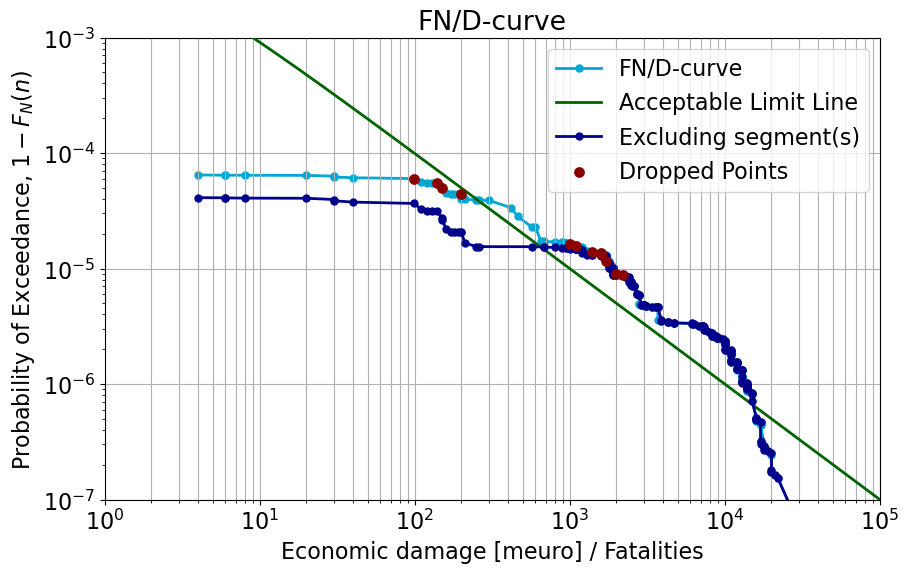

In [8]:
# Segment 12 (Katwijk scenarios) used at idx: [0,8,49]
segment_repaired = [12, 13]
segment_table = find_scenarios_with_segment_i(segment_repaired, df)
idx_segment = segment_table.index.values
print(f"Segment {segment_repaired} in scenarios {idx_segment}")

# idx_segment = [0, 8, 49]  # enter index of segment of interest
N_D_ordered_new, exceed_prob_new, complete_table_new = sensitivity_analysis(case, scenario_prob, idx_segment, N_D_ordered_test, exceed_prob_test, complete_table)

In [9]:
old_costs, new_costs, result = compute_benefit(complete_table, complete_table_new)
print(f"Old {choose_damage_or_fatality}: {old_costs}")
print(f"Old {choose_damage_or_fatality}: {new_costs}")
print(f"Difference: {result}")

Old fatality: 3.04187862305
Old fatality: 2.6691130726399996
Difference: 0.3727655504100005


## Assignment Answers

*You don't need to answer all of these questions, but they will probably help you arrive at a desicion.*



1. Which scenario contributes the most to risk?
2. Which dike segment contributes the most to risk?
3. Is there a certain region that seems to contribute more to risk?
4. The above questions look at risk, but you can also consider probability and consequences separately. If you look through these details, do you notice any segments or scenarios that stand out as contributing a lot (or a little)?
5. Which dike segments do you choose to repair, and why?
6. What is the total reduction in expected damages?
7. Could you get the entire curve to satisfy the safety criteria? What is needed in order to do so?
8. Consider the dike segments you chose to repair. How might you actually go about repairing them: would you focus on reducing the probability or the consequences? Make a few suggestions for how you would do each improvement and comment on the feasibility.